# Assignment 2: The Secrets of Optical Flow

Name: Tushar Choudhary  
Roll number: 2019111019

**Question 1.1**  

**Q1.** To slow down a video, we'll need to create additional frames. We can add duplicate frames but this will make the video appear choppy. To create a smoother video we need to add additional frames between currently known consecutive image pairs. This can be done by interpolating between the 2 images pairs. We can use optical flow to get the movement of the pixels from one frame to next frame, and once we know the path(displacement) a pixel takes, we can use linear interpolation to add as many frames in between as we wish. For example, if a pixel moves from frame1 to frame2 by (u,v) and we wish to add 2 more images between these frames, then we'll create 2 images where this pixel will be moved by (u/3, v/3) and (2u/3, 2v/3) respectively. This technique is called frame interpolation.  
  
**Q2.** To create a bullet time scene, we will take images of a scene using multiple cameras arranged in trajectory of point of view. These cameras will one by one click images to generate the bullet time scene. However, the number of cameras, and hence the number of images will be quite less than the required number of frames. Hence, we'll create additional frames between adjacent images pairs using interpolation. Similar to Q1, we'll use optical flow to get the distance moved by a pixel and based on the number of frames needed, we can interpolate this pixel's location in the new frames. In this case, the camera is moving and the object is usually still, however object flow still allows us to track the movement of the pixels making the interpolation possible.  
  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
from PIL import Image
import numpy as np
import random

import glob
import cv2
import os

# import imageio
from scipy import ndimage

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

https://medium.com/pixel-wise/detect-those-corners-aba0f034078b  
visualize the feature set of pixels obtained by both algorithms that will be tracked by the sparse LK method. 

In [3]:
#Define RGB2gray function
def rgb2gray(img) :
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

#Detemine gradient function for Fx and Fy using sobel filter(normlized)
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1],[0],[1]]))
    return grad_img/np.max(grad_img)

**Harris Corner Detector**

In [4]:
def harris_corner(img_pth, threshold_ratio = 0.01, k = 0.05, dis = 10):
    
    input_img = cv2.imread(img_pth)
    gray_input_img = rgb2gray(input_img) 
    # Not using cv2.cvtColor to avoid integral values

    Ix = gradient_x(gray_input_img)
    Iy = gradient_y(gray_input_img)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    window_results = [] 
    thresh_pts = []
    final_thresh_pts = [] 
    x_hcd = [] 
    y_hcd = []
    mx_res = 0

    for i in range(4, int(input_img.shape[0] - 4)):
            for j in range(4, int(input_img.shape[1] - 4)):
                H = [[0, 0], [0, 0]]
                # Taking window of size 9x9 and calculating Harris response value
                H[0][0] = np.sum(Ixx[i-4 : i+5 , j-4 : j+5])
                H[1][1] = np.sum(Iyy[i-4 : i+5 , j-4 : j+5])
                H[0][1] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                H[1][0] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                determinant = H[0][0] * H[1][1] - H[0][1] * H[1][0]
                trace = H[0][0] + H[1][1]
                res = determinant - k * trace * trace
                window_results.append((i, j, res))
                if(res > mx_res) :
                    mx_res = res

    # Choosing points of interest
    for window_res in window_results :
        i, j, res = window_res
        if res > threshold_ratio * mx_res :
            thresh_pts.append([i, j, res])
    
    print(f"Initially found {len(thresh_pts)} points of interest.")

    # Performing non-maximal supression
    sorted_thresh_pts = sorted(thresh_pts, key = lambda x: x[2], reverse = True)
    final_thresh_pts.append(sorted_thresh_pts[0][:-1])
    
    for i in sorted_thresh_pts :
        for j in final_thresh_pts :
            if(abs(i[0] - j[0] <= dis) and abs(i[1] - j[1]) <= dis) :
                break
        else :
            final_thresh_pts.append(i[:-1])
            x_hcd.append(i[1])
            y_hcd.append(i[0])
            
    print(f"After non-maximal supressions {len(final_thresh_pts)} points were left")
            
    print("Visualzing features of some interest points")
    
    if len(final_thresh_pts)>0:
        plt.imshow(gray_input_img[y_hcd[0]-4 : y_hcd[0]+5 , x_hcd[0]-4 : x_hcd[0]+5])
        plt.show()

    if len(final_thresh_pts)>35:
        plt.imshow(gray_input_img[y_hcd[35]-4 : y_hcd[35]+5 , x_hcd[35]-4 : x_hcd[35]+5])
        plt.show()

    if len(final_thresh_pts)>70:
        plt.imshow(gray_input_img[y_hcd[70]-4 : y_hcd[70]+5 , x_hcd[70]-4 : x_hcd[70]+5])
        plt.show()

    plt.imshow(input_img)
    plt.plot(x_hcd, y_hcd, '*', color='red')
    plt.savefig("../results/harris_corner_result.jpg")
    print("Image saved at ../results/harris_corner_result.jpg")
    plt.show()

Initially found 25063 points of interest.
After non-maximal supressions 126 points were left
Visualzing features of some interest points


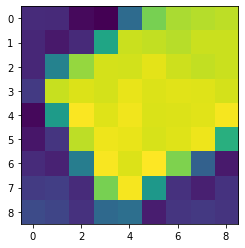

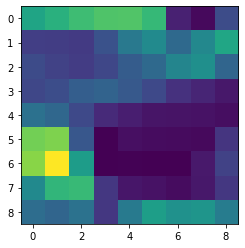

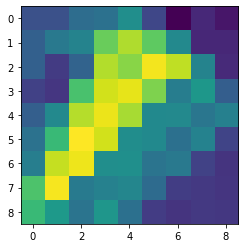

Image saved at ../results/harris_corner_result.jpg


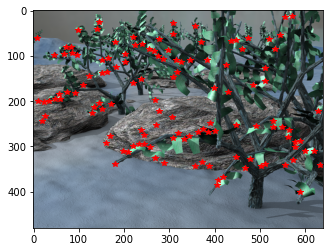

In [5]:
harris_corner('../data/all-frames-colour/Grove3/frame07.png', 0.05)

Result:  
We were able to obtain important points form the given image  
  
Important things to note:
* We need to adjust the threshold based on the number of points we want

**Shi-Tomasi Corner Detection**

In [6]:
def shi_tomasi(img_pth, threshold_ratio = 0.01, dis = 10):
    
    input_img = cv2.imread(img_pth)
    gray_input_img = rgb2gray(input_img) 
    # Not using cv2.cvtColor to avoid integral values

    Ix = gradient_x(gray_input_img)
    Iy = gradient_y(gray_input_img)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    window_results = [] 
    thresh_pts = []
    final_thresh_pts = [] 
    x_hcd = [] 
    y_hcd = []
    mx_res = 0

    for i in range(4, int(input_img.shape[0] - 4)):
            for j in range(4, int(input_img.shape[1] - 4)):
                H = [[0, 0], [0, 0]]
                # Taking window of size 9x9 and calculating Harris response value
                H[0][0] = np.sum(Ixx[i-4 : i+5 , j-4 : j+5])
                H[1][1] = np.sum(Iyy[i-4 : i+5 , j-4 : j+5])
                H[0][1] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                H[1][0] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                H = np.array(H)
                np.linalg.eig(H)
                w, v = np.linalg.eig(H)
                res = min(w[0], w[1])
                window_results.append((i, j, res))
                if(res > mx_res) :
                    mx_res = res
                    
    # Choosing points of interest
    for window_res in window_results :
        i, j, res = window_res
        if res > threshold_ratio * mx_res :
            thresh_pts.append([i, j, res])
    
    print(f"Initially found {len(thresh_pts)} points of interest.")

    # Performing non-maximal supression
    sorted_thresh_pts = sorted(thresh_pts, key = lambda x: x[2], reverse = True)
    final_thresh_pts.append(sorted_thresh_pts[0][:-1])
    
    for i in sorted_thresh_pts :
        for j in final_thresh_pts :
            if(abs(i[0] - j[0] <= dis) and abs(i[1] - j[1]) <= dis) :
                break
        else :
            final_thresh_pts.append(i[:-1])
            x_hcd.append(i[1])
            y_hcd.append(i[0])
            
    print(f"After non-maximal supressions {len(final_thresh_pts)} points were left")
            
    print("Visualzing features of some interest points")
    
    if len(final_thresh_pts)>0:
        plt.imshow(gray_input_img[y_hcd[0]-4 : y_hcd[0]+5 , x_hcd[0]-4 : x_hcd[0]+5])
        plt.show()

    if len(final_thresh_pts)>35:
        plt.imshow(gray_input_img[y_hcd[35]-4 : y_hcd[35]+5 , x_hcd[35]-4 : x_hcd[35]+5])
        plt.show()

    if len(final_thresh_pts)>70:
        plt.imshow(gray_input_img[y_hcd[70]-4 : y_hcd[70]+5 , x_hcd[70]-4 : x_hcd[70]+5])
        plt.show()

    plt.imshow(input_img)
    plt.plot(x_hcd, y_hcd, '*', color='red')
    plt.savefig("../results/harris_corner_result.jpg")
    print("Image saved at ../results/harris_corner_result.jpg")
    plt.show()

Initially found 18644 points of interest.
After non-maximal supressions 131 points were left
Visualzing features of some interest points


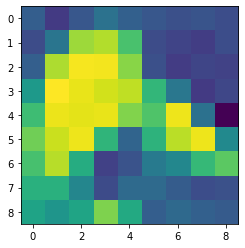

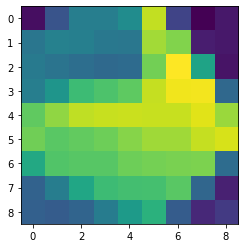

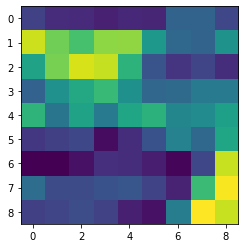

Image saved at ../results/harris_corner_result.jpg


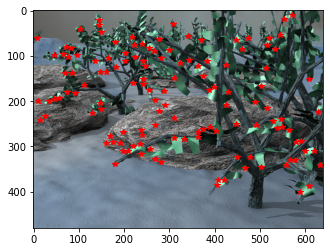

In [7]:
shi_tomasi('../data/all-frames-colour/Grove3/frame07.png', 0.2)

**Lukas-Kanade (LK) algorithm**

In [122]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, threshold):
    
    I1 = np.array(Img1)
    I1 = (I1 - np.mean(I1))/255
    I2 = np.array(Img2)
    I2 = (I2 - np.mean(I2))/255
    S = np.shape(I1)
    ws = windowSize

    # Applying Gaussian filter of size 3x3 to eliminate any noise
    I1_smooth = cv2.GaussianBlur(I1, (3,3), 0)
    plt.title('Image 1')
    plt.imshow(I1_smooth)
    plt.show()

    I2_smooth = cv2.GaussianBlur(I2, (3,3), 0)
    plt.title('Image 2')
    plt.imshow(I2_smooth)
    plt.show()
    
    Ix = signal.convolve2d(I1_smooth,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,0.25],[-0.25,0.25]],'same')
    Iy = signal.convolve2d(I1_smooth,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[0.25,0.25]],'same')
    It = signal.convolve2d(I1_smooth,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[-0.25,-0.25]],'same')
    
    u = v = np.nan*np.ones(S)
    
    for i in range(ws//2, int(S[0] - ws//2)):
        for j in range(ws//2, int(S[1] - ws//2)):
        
            IX = []
            IY = []
            IT = []
            
            for ii in range(-ws//2, ws//2):
                for jj in range(-ws//2, ws//2):
                    IX.append(Ix[i+ii, j+jj])
                    IY.append(Iy[i+ii, j+jj])
                    IT.append(It[i+ii, j+jj])
                    
            IX = tuple(IX)
            IY = tuple(IY)
            IT = [IT]
            IT = np.array(IT)
            IT = IT.T
            
            A = (IX, IY)
            A = np.matrix(A)
            A = A.T
            A_T = A.T
            
            A1 = np.dot(A_T,A)
            
            np.linalg.eig(A1)
            eigvalue, eigvector = np.linalg.eig(A1)
            res = min(eigvalue)
            
            if res>threshold:
                A2 = np.linalg.pinv(A1)
                A3 = np.dot(A2,A_T)
                (u[i,j],v[i,j]) = np.dot(A3,IT) 
  
    c='r'
    plt.title('Vector plot of Optical Flow for some features')
    plt.imshow(I1)
    for i in range(S[0]):
        for j in range(S[1]):
            if u[i,j]!=np.nan and v[i,j]!=np.nan and (abs(u[i,j])>1 or abs(v[i,j])>1) and np.random.rand()>0.98:
                plt.arrow(j,i,v[i,j],u[i,j],head_width = 5, head_length = 5, color = c)

    plt.show()

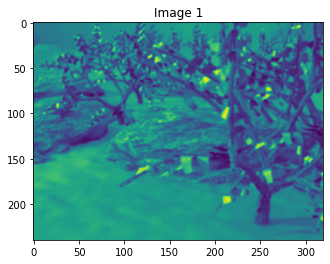

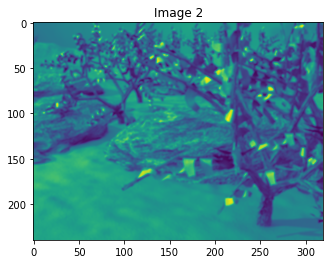

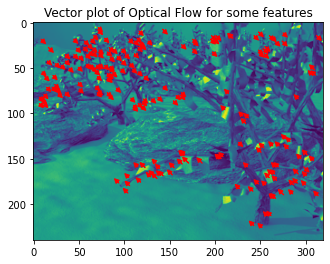

In [123]:
newsize = (320, 240)
Image1 = Image.open('../data/all-frames-colour/Grove3/frame10.png').convert('L')
Image2 = Image.open('../data/all-frames-colour/Grove3/frame11.png').convert('L')
Image1 = Image1.resize(newsize)
Image2 = Image2.resize(newsize)
LukasKanadeForwardAdditive(Image1, Image2, 11, 0.01)